In [1]:
# !pip3 install -q -r requirements.txt
# !pipreqsnb --force

## [Proceed to results](#results)

In [95]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np
import time

from IPython import display
import imageio
import os
FP = './animations'

In [449]:
from Frozen_Lake import FrozenLakeEnv
from functools import wraps
import contextlib
import io
from itertools import product


class FrozenLakeConvenient(FrozenLakeEnv):
    def ida(method):
        """static decorator, replaces all int action inputs by corresponding strings
        NB! numpy.ndarray int32 doesn't count as int thus must be converted to int before calling any decorated methods"""
        @wraps(method) # to maintain __name__
        def inner(*margs, **mkwargs):
            s = margs[0]
            margs_aid = [s.actions[a] if isinstance(a, int) else a for a in margs]
            mkwargs_aid = {k: (s.actions[v] if isinstance(v, int) else v) for k, v in mkwargs.items()}
            return method(*margs_aid, **mkwargs_aid)
        return inner
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.actions = ['left', 'down', 'right', 'up']
        self.n_actions = len(self.actions) #4
        self.actions_d = {a: i for i, a in enumerate(self.actions)}
        self.states = self.get_all_states()
        self.states_d = {s: i for i, s in enumerate(self.states)}
        self.n_states = len(self.get_all_states()) #16
        self.R = self.build_reward() #R_ass'
        self.P = self.build_transition() #P_ass'
        self.PR = np.einsum('ijk, ijk -> ij', self.P, self.R)
        
    def rr(self, capture=False):
        """alternative rgba render on top of FrozenLake text render"""
        # create 4-colour palette
        palette = ('#F875AA','#AEDEFC','#FFF6F6','#FFDFDF')
        # intercept print ascii output to stdout
        string_buffer = io.StringIO()
        with contextlib.redirect_stdout(string_buffer):
            self.render()
        raw_out = string_buffer.getvalue()
        out = [[*l] for l in raw_out.split('\n')[:4]]
        # convert nested list of strings to numpy string array
        out_a = np.array(out)
        unique_chars, matrix = np.unique(out_a, return_inverse=True)
        # variable context manager
        with plt.ioff() if capture else contextlib.nullcontext():
            ax = sns.heatmap(matrix.reshape(out_a.shape), annot=out_a, fmt='', annot_kws={'fontsize': 20}, cbar=False, square=True, lw=0.5, cmap=ListedColormap(palette))
            ax.set_axis_off()
            if capture:
                canvas = plt.gcf().canvas
                canvas.draw()
                # reshape from 1D array to HWC (RGBA) default
                data = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8).reshape(*canvas.get_width_height(), 4)
                plt.close()
                return data
                

    def gpa(self, *args, **kwargs): # do not overwrite as it's used for the other methods internally
        return list(self.actions_d[a] for a in super().get_possible_actions(*args, **kwargs))
        
    @ida              
    def step(self, action):
        """filters unnecessary output [state, reward, done, info, ...]"""
        return super().step(action)[:3]
        
    @ida
    def get_next_states(self, *args, **kwargs):
        return super().get_next_states(*args, **kwargs)
        
    @ida 
    def get_reward(self, *args, **kwargs):
        return super().get_reward(*args, **kwargs)
        
    @ida # for some reason this particular method also works wo decoration
    def get_transition_prob(self, *args, **kwargs):
        return super().get_transition_prob(*args, **kwargs)

    def build_reward(self):
        """creates 3D reward tensor"""
        R_ = np.full(shape=(self.n_actions, self.n_states, self.n_states), fill_value=0., dtype=np.half) # NaN filling
        unrc = 0
        # retrieves all possible combinations of 3 elements
        for a, s, ns in product(range(self.n_actions), range(self.n_states), range(self.n_states)):
            try:
                R_[a, s, ns] = self.get_reward(self.states[s], a, self.states[ns])
            except AssertionError:
                unrc += 1
        print(f"Reward building procedure leaves out {unrc} unreachable states of {self.n_actions * self.n_states**2} and that's ok")
        return R_
        
    def build_transition(self):
        """creates 3D transition probabilities tensor"""
        TP_ = np.full(shape=(self.n_actions, self.n_states, self.n_states), fill_value=0., dtype=np.half)
        unrc = 0
        # retrieves all possible combinations of 3 elements
        for a, s, ns in product(range(self.n_actions), range(self.n_states), range(self.n_states)):
            try:
                TP_[a, s, ns] = self.get_transition_prob(self.states[s], a, self.states[ns])
            except AssertionError:
                unrc += 1
        print(f"Transition building procedure leaves out {unrc} unreachable states of {self.n_actions * self.n_states**2} and that's ok")
        return TP_

In [450]:
ENV = FrozenLakeConvenient()
# sanity check
(np.isnan(ENV.P) == np.isnan(ENV.R)).all()
np.count_nonzero(ENV.PR)

Reward building procedure leaves out 320 unreachable states of 1024 and that's ok
Transition building procedure leaves out 320 unreachable states of 1024 and that's ok


3

In [769]:
# ENV.reset()
# ENV.step(1)
# ENV.step(1)
# ENV.rr()

In [770]:
class RandAgent():
    """baseline agent that performs random action"""
    def __init__(self, n_actions=ENV.n_actions):
        self.n_actions = n_actions
        self.rendered_frames = []
        
    def act(self, state):
        action = np.random.choice(np.arange(self.n_actions)).item()
        # print('RANDOM!!')
        return action

    def capture(self, max_length, fpath=FP):
        """captures render output and creates gif animation from frames"""
        self.rendered_frames = []
        self.walk(max_length, render=2)
        name = ENV.__class__.__name__ + '.gif'
        path = os.path.join(fpath, name)
        imageio.mimsave(path, ims=self.rendered_frames, fps=30)
        print(f'Capture result has been saved to {path}')
        # otherwise the other plots won't be shown
        plt.ion()
        plt.pause(0.0001)

    def walk(self, max_length, render=False, injected=10, **actkwargs):
        """take max_length actions by agent N"""
        states, actions, rewards = [], [], []
        # initialization state
        state = ENV.reset()
        for i in range(max_length):
            # perform an action
            action = self.act(state, **actkwargs)
            new_state, reward, done = ENV.step(action)
            # log 
            actions.append(action)
            states.append(state) # append OLD state, everything breaks if you start from new
            rewards.append(reward)
            state = new_state
            # continuous visualization w/ proper interrupt
            if render:
                try:
                    if render == 2:
                        arr = ENV.rr(capture=True)
                        self.rendered_frames.append(arr)
                    else:
                        ENV.rr()
                        display.display(plt.gcf())
                        time.sleep(1e-4)
                        display.clear_output(wait=True)
                except KeyboardInterrupt:
                    break
            if done or ENV.is_terminal(new_state):
                break
        trajectory = {'s': states,
                        'a': actions,
                            'r': rewards,}
        return trajectory

In [772]:
agent = RandAgent()
results = agent.walk(max_length=10)
sum(results['r'])

0.0

In [773]:
class ContraMap:
    """Contracting map, affine transformation"""
    def __init__(self, gamma):
        self.gamma = gamma
    def __call__(self, V):
        return ENV.PR + self.gamma * np.tensordot(ENV.P, V, 1) # a,s = 4,16 matrix
        
class ContraMapPolicy(ContraMap):
    """Contracting map defined by current policy, affine transformation of value function V"""
    def __init__(self, policy_matrix, gamma=0.9):
        super().__init__(gamma)
        self.policy = policy_matrix # 2D policy tensor
        self.base_call = super().__call__ # invokes call method of a parent class
    def contract(self, env_tensor):
        """contracts environmental 3D tensor env_ass' (or 2D tensor env_as) with 2D policy"""
        return np.einsum('ij..., ji -> j...', env_tensor, self.policy) # ~ np.transpose(np.diagonal(np.tensordot(e, policy, 1), axis1=0, axis2=1))
    def __call__(self, V):
        return self.contract(self.base_call(V))

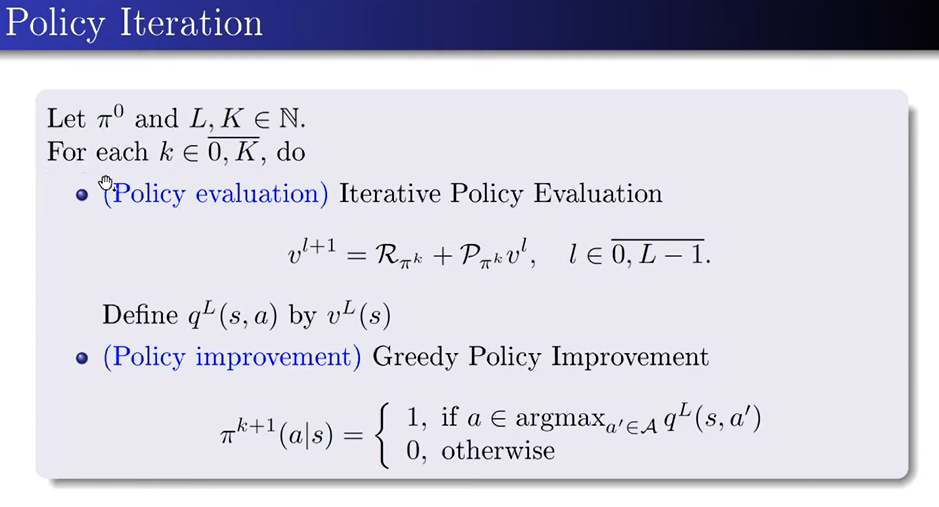

In [784]:
class DynAgent(RandAgent):
    def __init__(self, n_actions=ENV.n_actions, n_states=ENV.n_states):
        """base dynamic programming actor, optimizes reward by policy"""
        super().__init__(n_actions)
        self.n_states = n_states
        self.aid_to_str = ['◄', '▼', '►', '▲']
        self.policy = np.ones((self.n_states, self.n_actions))/self.n_actions # uniform policy initialisation (sa)

    def act(self, state):
        """random sample from current distribution on actions"""
        action = np.random.choice(self.n_actions, p=self.policy[ENV.states_d[state]]) # unlike parent class's, output here is just int thus doesn't require .item()
        return action

    def show_policy(self, label=None):
        """plots current policy matrix self.sa as a heatmap"""
        plt.figure(figsize=(2,5))
        concise_actions = {'yticklabels': ENV.states, 'xticklabels': self.aid_to_str} if self.aid_to_str else {}
        ax = sns.heatmap(self.policy, **concise_actions, cbar=False, lw=0.2)
        ax.set_title(label if label else 'Current policy')
        return ax

class PolicyIterationAgent(DynAgent):
    def __init__(self, n_actions=ENV.n_actions, n_states=ENV.n_states):
        """Policy Iteration algorithm actor, optimizes value function by policy"""
        super().__init__(n_actions, n_states)

    def fit(self, n_iterations, n_vf_iterations, gamma=0.9, verbose=None):
        dh = display.display(display_id=True)
        V = np.zeros((self.n_states))  # zero value-function initialization
        for i in range(n_iterations):
            cm = ContraMapPolicy(self.policy, gamma=gamma)
            # iterative policy evaluation
            # V = np.zeros((self.n_states))  # zero value-function initialization
            # iterative approximation of value function V
            for l in range(n_vf_iterations):
                V = cm(V)
            q = cm.base_call(V) # get action-value function by V
            # greedy policy improvement
            best_actions = np.argmax(q, axis=0) # 1D array of 16 'best' actions
            # one-hot encoding of best_actions array (used it to choose rows from Id)
            self.policy = np.eye(self.n_actions)[best_actions] 
            
            # visualization (plotting starts after at least 1 iteration)
            if verbose and (i + 1) % verbose == 0:
                ax = self.show_policy()
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

class ValueIterationAgent(DynAgent):
    def __init__(self, n_actions=ENV.n_actions, n_states=ENV.n_states):
        """Value Iteration algorithm actor, optimizes value function and yields optimal policy based on that"""
        super().__init__(n_actions, n_states)

    def fit(self, n_iterations, n_vf_iterations, gamma=0.9, verbose=None):
        dh = display.display(display_id=True)
        cmb = ContraMap(gamma=gamma) # contracting operator without policy
        # iterative policy evaluation
        Vo = np.zeros((self.n_states))  # zero value-function initialization
        # iterative approximation of optimal value function Vo
        for l in range(n_vf_iterations):
            Vo = np.argmax(cmb(Vo), axis=0)
        qo = cmb(Vo) # get optimal action-value function by Vo
        
        # optimal policy is defined as greedy policy on optimal value function
        best_actions = np.argmax(qo, axis=0) # 1D array of 16 'best' actions
        # one-hot encoding of best_actions array (used it to choose rows from Id)
        self.policy = np.eye(self.n_actions)[best_actions]
        
        # visualization (plotting starts after at least 1 iteration)
        if verbose:
            ax = self.show_policy()
            dh.update(plt.gcf())
            plt.close() # because plt.clf() is spurious

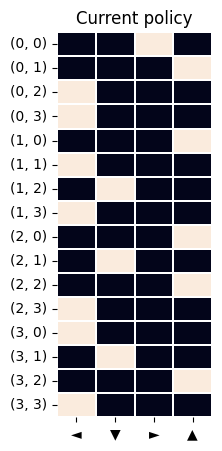

In [783]:
va = ValueIterationAgent()
va.fit(n_iterations=None, n_vf_iterations=1000, gamma=0.9, verbose=1)

0.0

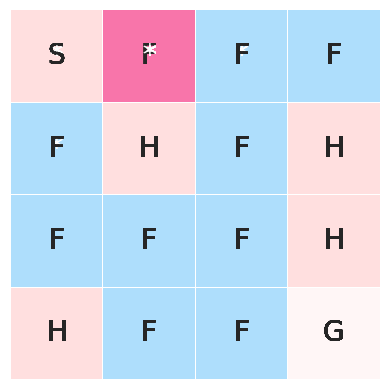

In [781]:
results = va.walk(30, render=True)
sum(results['r'])

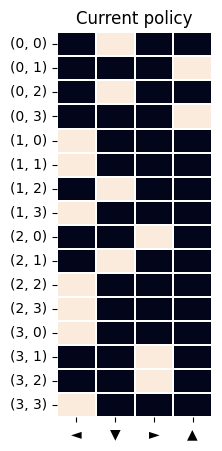

In [807]:
pa = PolicyIterationAgent()
pa.fit(n_iterations=20, n_vf_iterations=20, gamma=0.99, verbose=1)

0.0

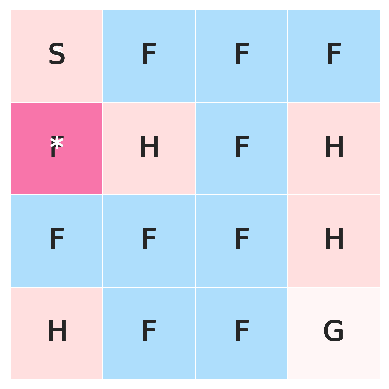

In [794]:
results = pa.walk(20, render=True)
sum(results['r'])

In [666]:
def run(K, L, M=1000, gamma=0.99):
    pa_ = PolicyIterationAgent()
    pa_.fit(n_iterations=K, n_vf_iterations=L, gamma=gamma)
    rewards = []
    for _ in range(M):
        results = pa_.walk(50)
        reward = sum(results['r'])
        rewards.append(reward)
    return np.mean(rewards)

def GS(size=20):
    m = np.zeros((size, size))
    for pair in product(range(1, size), range(1, size)):
        m[pair] = run(*pair)
    return m

In [795]:
iter_data = np.array([run(k, 10) for k in range(20)])
iter_vf_data = np.array([run(10, l) for l in range(20)])
iter_g_data = np.array([run(10, 10, gamma=g) for g in np.arange(0.95, 1.0, 0.0001)])

Text(0.5, 1.0, 'Reward')

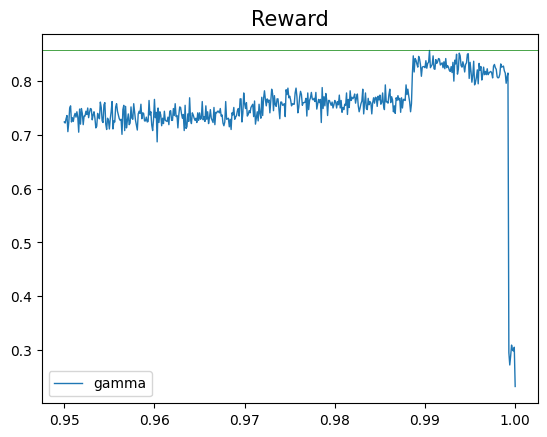

In [798]:
ax = sns.lineplot(x=np.arange(0.95, 1.0, 0.0001), y=iter_g_data, linewidth=1, label='gamma')
ax.axhline(y=max(iter_g_data), color='g', linestyle='-', linewidth=0.5)
ax.set_title(f"Reward", fontsize=15)

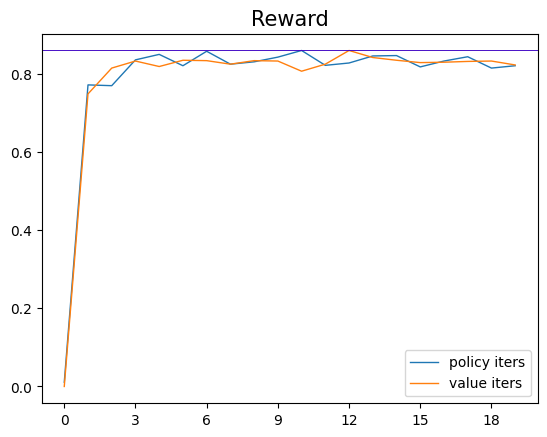

In [796]:
ax = sns.lineplot(iter_data, linewidth=1, label='policy iters')
ax = sns.lineplot(iter_vf_data, linewidth=1,ax=ax, label='value iters')
ax.axhline(y=max(iter_data), color='r', linestyle='-', linewidth=0.5)
ax.axhline(y=max(iter_vf_data), color='b', linestyle='-', linewidth=0.5)
ax.set_title(f"Reward", fontsize=15)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [801]:
res = GS()

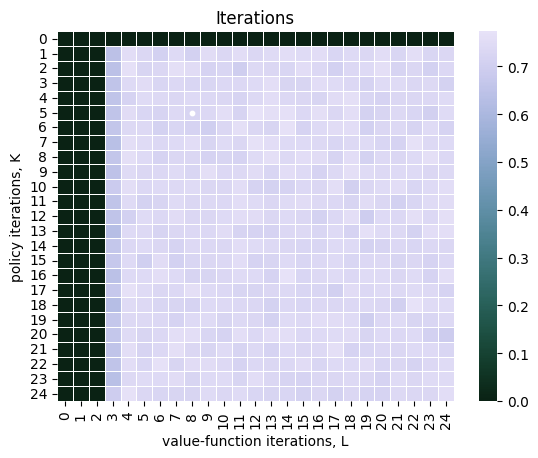

In [804]:
ax = sns.heatmap(m, lw=0.5, cmap=sns.cubehelix_palette(start=2, rot=0.4, dark=0.1, light=0.9, reverse=True, as_cmap=True))
ax.set_title('Iterations')
ax.set_ylabel('policy iterations, K')
ax.set_xlabel('value-function iterations, L')
# ax.tick_params(axis='x', rotation=45)
best = np.where(res == np.max(res))
ax.scatter(0.5+best[1], 0.5+best[0], color='w', s=10)

<a id="results"></a>

# Results
I've managed to implement fully vectorized policy iteration algorithm via numpy framework (and that shouldn't be taken for granted). 

In other words, not only it converges as should but all intermediate operations are as effective as possible
## Policy Iteration
### Amount of iterations
We don't need any policy iterations for convergence, the only thing that matters is quality of value function $V^{L}$ approximation

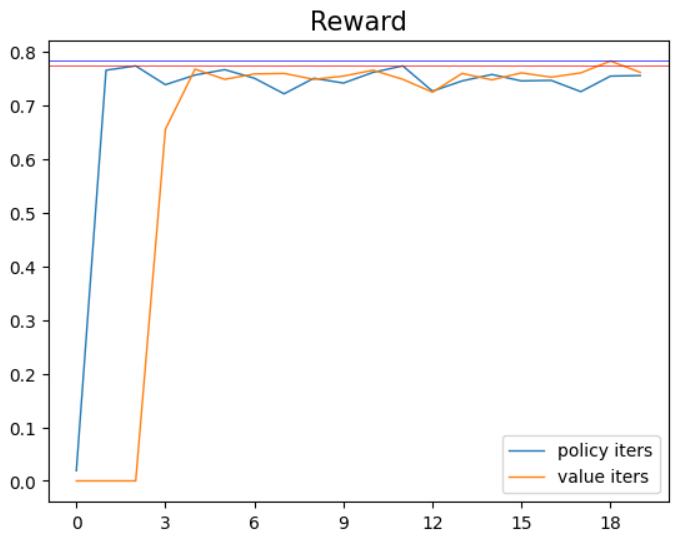

Corresponding iteration procedure requires at least $L=3$ iterations to be useful and $L>4$ to become meaningless (enters indistinguishable region)

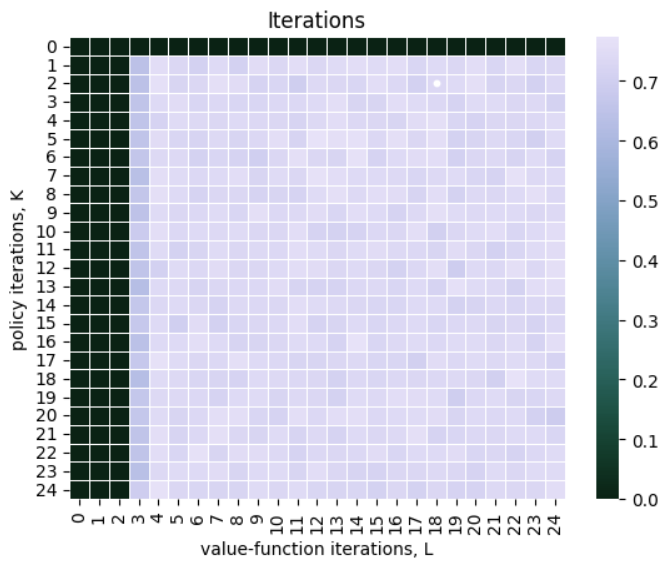
### Discount choice
I've noticed that larger discount coefficient $\gamma > 0.975$ yields better results

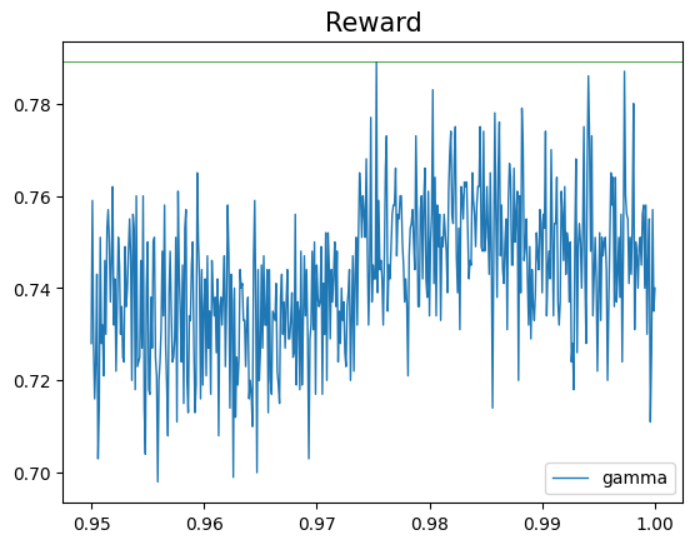

I've decided to investigate this behaviour and compared final policies at $\gamma = 0.9, 0.99, 0.999$

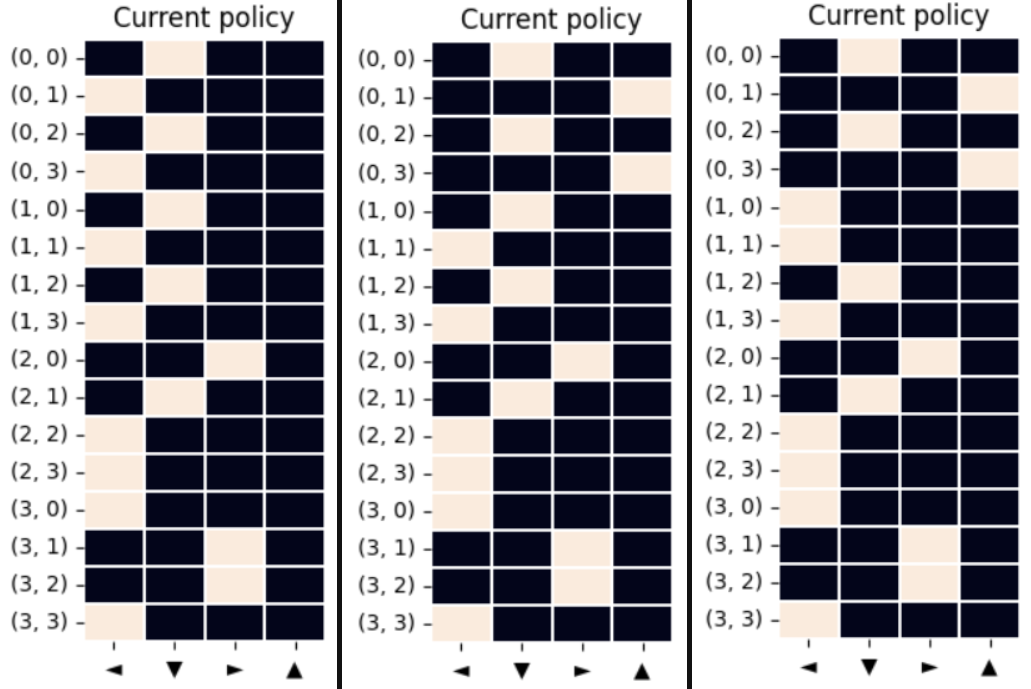

It seems a bit better (for longer run) to go up in (0, 1) and (0, 3) states instead of left and go left instead of down in (1,0)

Despite these actions are directed towards the wall, slippery environment makes them better than 'normal'

### Interesting stuff
Policy defines 'left' action for all unreachable spots (holes, goal), that doesn't mean we actually move like that, contracting map doesn't change them and argmax takes first maximum of 4 equal values in turn

## Value-function re-initialization
If we don't re-init $V(s)\equiv 0$ at each policy iteration, we get much better convergence in less $V(s)$ approximation iterations, higher mean reward and stability. 

Resulting optimal policy is identical to one from previous case thus better results here are caused by more frequent (optimal) policy discoveries 

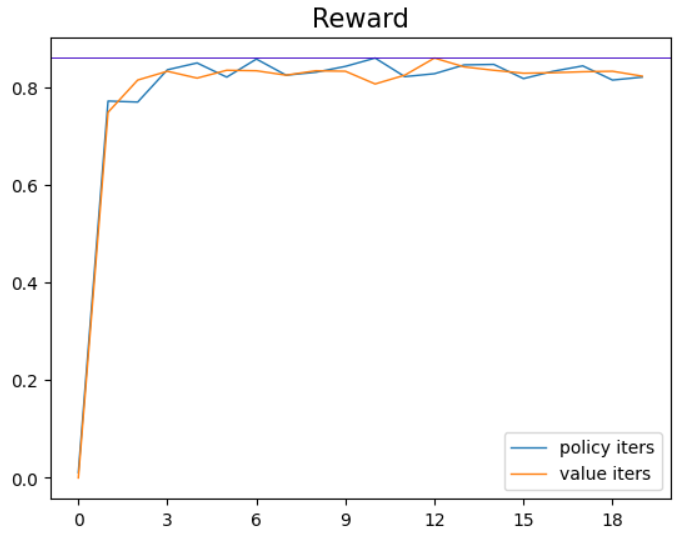
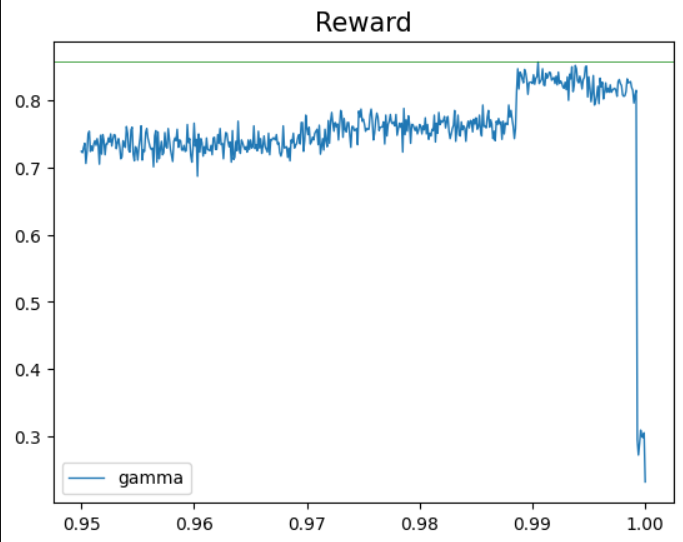
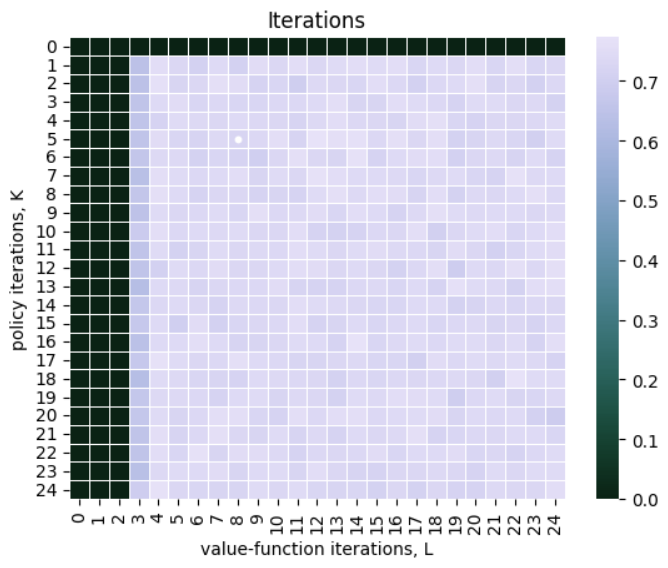
## Value Iteration